In [1]:
import os
import sys

import glob
import json

# from tqdm.auto import tqdm
from tqdm import tqdm

import re

import time

from matplotlib import pyplot

import msgpack
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import pearsonr, spearmanr

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))
from utility.minio.cmd import connect_to_minio_client

In [32]:
from utility.active_learning.samples import representative_sample_selection

# load from minio

In [3]:
ROOT = '../dataset/'

DATASETs = [
    'environmental', 
    'character', 
    'icons', 
    'mech', 
    'waifu',
    'propaganda-poster'
]

In [4]:
# MINIO_ADDRESS = "123.176.98.90:9000"
MINIO_ADDRESS = "192.168.3.5:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"
bucket_name = 'datasets'

In [5]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [20]:
def load_vision_embs(dataset_name, n_image_per_folder):

    folders = list()
    for i in client.list_objects(bucket_name, dataset_name + '/', recursive=False):
        name = i.object_name
        results = re.search(r'/(\d+)/', name)
        if results is None:
            continue
        folders.append(results.groups()[0])

    vision_embs = list()
    
    for folder in tqdm(sorted(folders), leave=False):

        cnt = 0
        
        for i in client.list_objects(bucket_name, f'{dataset_name}/{folder}', recursive=True):
            
            object_name = i.object_name
            
            if not object_name.lower().endswith('_clip.msgpack'):
                continue
                
            try:
                
                data = client.get_object(bucket_name, object_name).data
                decoded_data = msgpack.unpackb(data)

                vision_embs.append(np.array(decoded_data['clip-feature-vector']))

                cnt += 1

            except KeyboardInterrupt:
                return
            except:
                continue

            if cnt >= n_image_per_folder:
                break
        
    return vision_embs

In [23]:
vision_embs = list()
for dataset_name in DATASETs:
    vision_embs.extend(load_vision_embs(dataset_name, n_image_per_folder=100))
vision_embs = np.concatenate(vision_embs, axis=0)

In [26]:
np.save('data/vision_embs.npy', vision_embs.astype('float32'))

# load npy

In [3]:
generated_vision_embs = np.load('data/vision_embs.npy')
sub_vision_embs = np.load('data/vision_embs.npy')

In [4]:
vision_embs = np.concatenate([generated_vision_embs, sub_vision_embs], axis=0)

In [5]:
x = vision_embs #/ np.linalg.norm(vision_embs, axis=-1, keepdims=True)

# PCA

## fit

In [93]:
pca = PCA()

In [94]:
z = pca.fit_transform(x)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_

## save

In [105]:
np.savez(
    'data/pca.npz', 
    mean=pca.mean_,
    components=pca.components_,
    explained_variance=pca.explained_variance_,
    explained_variance_ratio=pca.explained_variance_ratio_,
    singular_values=pca.singular_values_    
)

## load

In [6]:
npz = np.load('data/pca.npz')

In [7]:
explained_variance_ratio = npz['explained_variance_ratio']
components = npz['components']

# analysis

Text(0.5, 1.0, 'factor variance ratio of PCA')

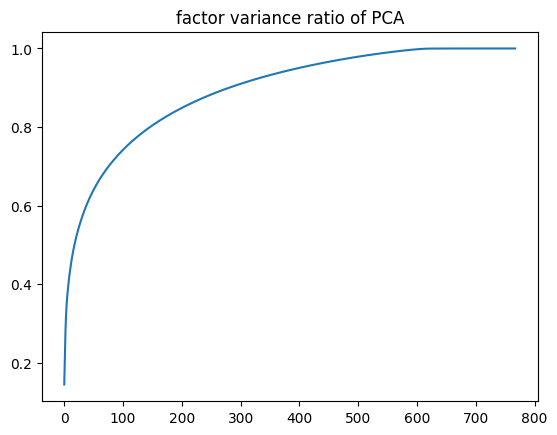

In [17]:
pyplot.plot(np.cumsum(explained_variance_ratio))
pyplot.title('factor variance ratio of PCA')

In [11]:
def cosine_similarity_vector(group1, group2):
        
    dot_product = np.sum(group1 * group2, axis=1)
    
    norm_group1 = np.linalg.norm(group1, axis=1)
    norm_group2 = np.linalg.norm(group2, axis=1)
    
    cosine_similarity = dot_product / (norm_group1 * norm_group2)

    return cosine_similarity

In [12]:
indices_a = np.random.choice(x.shape[0], 10000, False)
indices_b = np.random.choice(x.shape[0], 10000, False)

In [13]:
csv = cosine_similarity_vector(x[indices_a], x[indices_b])

In [10]:
# z = np.dot(x - pca.mean_, pca.components_.T[:, :48])
z = np.dot(x, components.T[:, :24])

In [14]:
csv_z = cosine_similarity_vector(z[indices_a], z[indices_b])

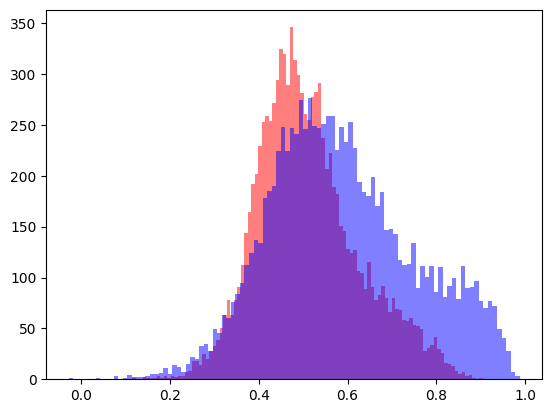

In [15]:
_ = pyplot.hist(csv, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(csv_z, bins=100, color='b', alpha=0.5)

In [16]:
pearsonr(csv, csv_z), spearmanr(csv, csv_z)

(PearsonRResult(statistic=0.9284874116828739, pvalue=0.0),
 SignificanceResult(statistic=0.9178646736944435, pvalue=0.0))

# kmeans

## 4096

In [8]:
kmeans = MiniBatchKMeans(n_clusters=4096, max_iter=100, n_init=3, batch_size=65536)

In [17]:
h = z / np.linalg.norm(z, axis=-1, keepdims=True)

In [18]:
labels = kmeans.fit_predict(h)

In [26]:
cluster_centers_4096 = kmeans.cluster_centers_.copy()

In [22]:
m = cosine_similarity(kmeans.cluster_centers_)

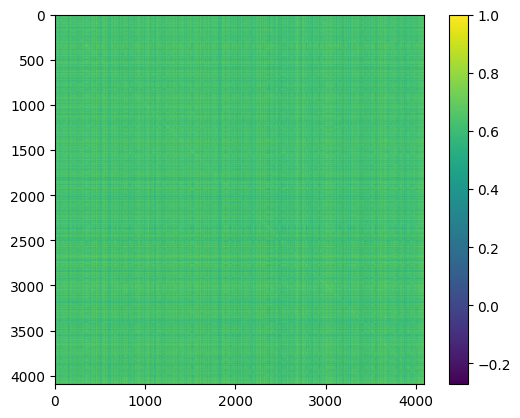

In [23]:
pyplot.imshow(m)
pyplot.colorbar()

## 1024

In [43]:
kmeans = KMeans(n_clusters=1024, max_iter=100, n_init=3)

In [44]:
h = cluster_centers_4096 / np.linalg.norm(cluster_centers_4096, axis=-1, keepdims=True)

In [45]:
labels = kmeans.fit_predict(h)

In [46]:
cluster_centers_1024 = kmeans.cluster_centers_.copy()

In [47]:
m = cosine_similarity(kmeans.cluster_centers_)
# np.fill_diagonal(m, 0.)

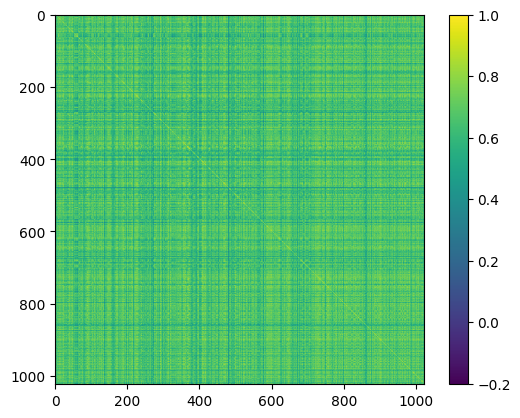

In [48]:
pyplot.imshow(m)
pyplot.colorbar()

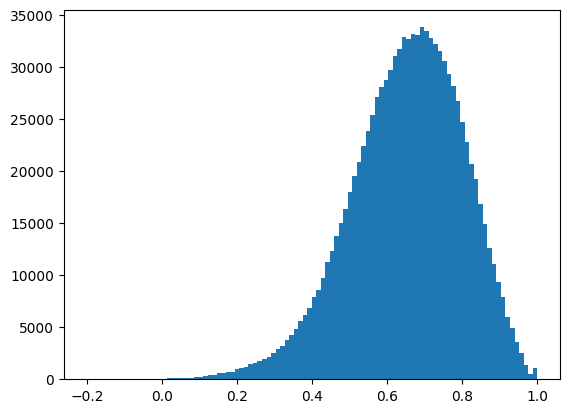

In [49]:
_ = pyplot.hist(m.flatten(), bins=100)

## 48

In [37]:
non_redundant_indices = representative_sample_selection(cluster_centers_4096, threshold=0.2, distance_type='cosine')

  0%|          | 0/4095 [00:00<?, ?it/s]

In [38]:
len(non_redundant_indices)

48

In [39]:
m = cosine_similarity(cluster_centers_4096[non_redundant_indices])

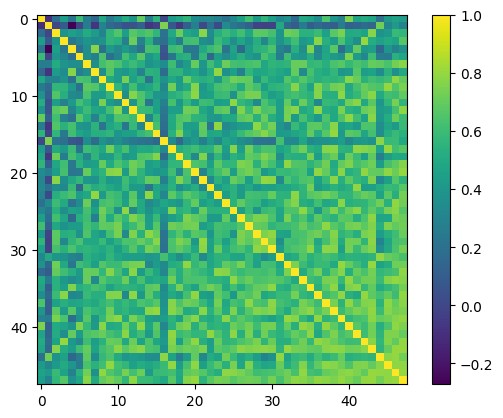

In [40]:
pyplot.imshow(m)
pyplot.colorbar()

## save

In [50]:
np.savez(
    'data/kmeans.npz', 
    cluster_centers_4096=cluster_centers_4096,
    cluster_centers_1024=cluster_centers_1024,
    cluster_centers_48=cluster_centers_4096[non_redundant_indices],
)